Sport Celebrity Image Classification

In [2]:
!pip3 install opencv-python

In [3]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**(1) Preprocessing:Detect Face and Eyes**

When we look at any image, most of the time we identify a person using a face. An image might conatin multiple faces, also the face can be structured and not clear. The first strp in our pre-processing is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it

**Now how do you detect face and eyes?**

we will use haar cascade from opencv for this!!

In [4]:
img = cv2.imread('C:/Users/ABHISHEK JHA/OneDrive/Desktop/1stop/vk.jpg')
img.shape

(1350, 1080, 3)

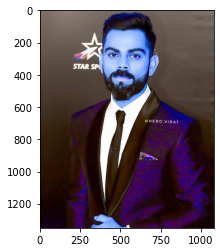

In [5]:
plt.imshow(img)

In [6]:
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1350, 1080)

In [7]:
gray

array([[111, 111, 111, ..., 114, 114, 114],
       [111, 111, 111, ..., 114, 114, 114],
       [111, 111, 111, ..., 114, 114, 114],
       ...,
       [  9,   9,   9, ...,   6,   6,   6],
       [  9,   9,   9, ...,   6,   6,   6],
       [  9,   9,   9, ...,   6,   6,   6]], dtype=uint8)

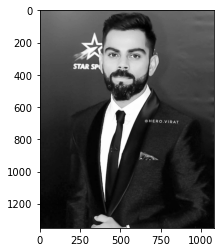

In [8]:
plt.imshow(gray, cmap='gray')

How to detect face and eyes from the image so that we can crop those images

In [11]:
face_cascade = cv2.CascadeClassifier('C:/Users/ABHISHEK JHA/OneDrive/Desktop/1stop/HaarCascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('C:/Users/ABHISHEK JHA/OneDrive/Desktop/1stop/HaarCascades/haarcascade_eye.xml')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[333, 130, 368, 368]])

In [12]:
(x,y,w,h) = faces[0]
x,y,w,h

(333, 130, 368, 368)

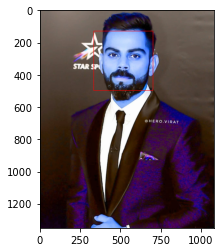

In [13]:
face_img = cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
plt.imshow(face_img)

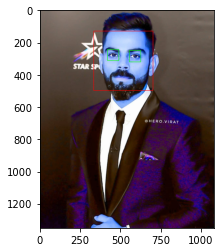

In [16]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew,ey+eh), (0,255,0),2)
        
plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

(2)Preprocessing:Crop the facial region of the image

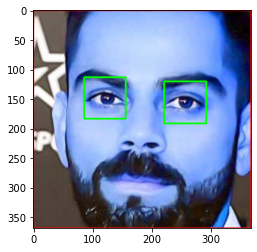

In [18]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [19]:
cropped_img=np.array(roi_color)
cropped_img.shape

(368, 368, 3)

(3)Preprocessing:Use wavelet transform as a feature for training our model

In wavelet transformed image, you can see clearly and that can give us clues on various facial features such as eyes, nose, lips etc

WAVELET TRANsFORM

In [22]:
import numpy as np
import pywt
import cv2

def w2d(img, mode='haar', level=1):
    imArray = img
    #datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    #convert to float
    imArray = np.float32(imArray)
    imArray /= 255;
    #compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    
    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;
    
    #reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

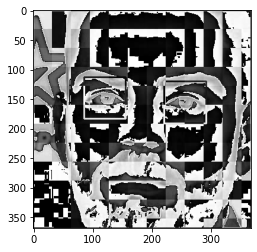

In [23]:
im_har = w2d(cropped_img, 'db1', 5)
plt.imshow(im_har, cmap='gray')

You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

(3)Preprocessing:Load image, detect face. If eyes>=2, then save and crop the face region

Lets write a python function that can take input image and returns cropped image(if face and eyes>=2 are detected)

In [24]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >=2:
            return roi_color

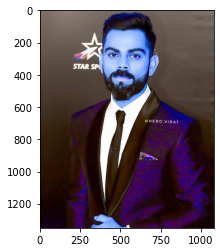

In [25]:
original_image = cv2.imread('C:/Users/ABHISHEK JHA/OneDrive/Desktop/1stop/vk.jpg')
plt.imshow(original_image)

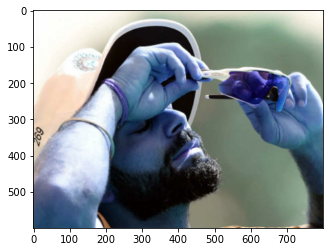

In [26]:
cropped_image = cv2.imread('C:/Users/ABHISHEK JHA/OneDrive/Desktop/1stop/vk1.jpg')
plt.imshow(cropped_image)

In [27]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('C:/Users/ABHISHEK JHA/OneDrive/Desktop/1stop/vk1.jpg')
cropped_image_no_2_eyes

In below image face is not very clear and it doesn't have two eyes clearly visible

Above cropped_image_no_2_eyes is None which means we shoud ignore this image and we will not use such image for model training

In [61]:
path_to_data = 'C:/Users/ABHISHEK JHA/OneDrive/Desktop/1stop/DataSets/'
path_to_cr_data = 'C:/Users/ABHISHEK JHA/OneDrive/Desktop/1stop/DataSets/cropped/'

In [62]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [63]:
img_dirs

['C:/Users/ABHISHEK JHA/OneDrive/Desktop/1stop/DataSets/Dhoni',
 'C:/Users/ABHISHEK JHA/OneDrive/Desktop/1stop/DataSets/Selena',
 'C:/Users/ABHISHEK JHA/OneDrive/Desktop/1stop/DataSets/Virat Kohli']

Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code

In [64]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [65]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count=1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ", cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  C:/Users/ABHISHEK JHA/OneDrive/Desktop/1stop/DataSets/cropped/Dhoni
Generating cropped images in folder:  C:/Users/ABHISHEK JHA/OneDrive/Desktop/1stop/DataSets/cropped/Selena
Generating cropped images in folder:  C:/Users/ABHISHEK JHA/OneDrive/Desktop/1stop/DataSets/cropped/Virat Kohli


In [66]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count+1
class_dict

{'Dhoni': 0, 'Selena': 1, 'Virat Kohli': 2}

Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classofoer images to taain our classifier. Let's prepare X and y now

In [68]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32,32))
        img_har = w2d(img, 'db1', 5)
        scalled_img_har = cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3, 1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [69]:
len(X[0])

4096

In [70]:
32*32*3 + 32*32

4096

In [71]:
X[0]

array([[110],
       [125],
       [134],
       ...,
       [ 82],
       [ 95],
       [ 82]], dtype=uint8)

In [72]:
y[0]

0

In [73]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(15, 4096)

Data Cleaning process is done. Now we are ready to train our model

We will use SVM with rbf kernel tuned with heuristic finetuning

In [74]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.75

In [79]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         2
           2       0.50      1.00      0.67         1

    accuracy                           0.75         4
   macro avg       0.50      0.67      0.56         4
weighted avg       0.62      0.75      0.67         4



C:\Users\ABHISHEK JHA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let's use gridSearch to try out different models with different paramets. Goal is to come up with best mode with best fine tuned parameters

In [80]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [81]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto', probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf', 'linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [82]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model':algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df

C:\Users\ABHISHEK JHA\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\ABHISHEK JHA\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\ABHISHEK JHA\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


,model,best_score,best_params
0,svm,0.666667,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.633333,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.466667,{'logisticregression__C': 1}


In [83]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [84]:
best_estimators['svm'].score(X_test,y_test)

0.75

In [85]:
best_estimators['random_forest'].score(X_test,y_test)

0.75

In [86]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.75

In [87]:
best_clf = best_estimators['svm']

In [89]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[0, 0, 1],
       [0, 2, 0],
       [0, 0, 1]], dtype=int64)

Text(69.0, 0.5, 'Truth')

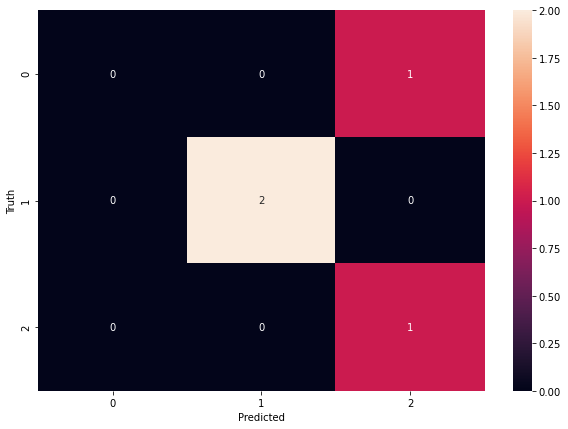

In [90]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [91]:
class_dict

{'Dhoni': 0, 'Selena': 1, 'Virat Kohli': 2}

Save the trained model

In [92]:
!pip install joblib
import joblib
#save the model as a pickle in a file
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

Save class dictionary

In [93]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))